<img src="https://upload.wikimedia.org/wikipedia/commons/d/df/Logo_UNIR.png" width="350" height="175">

# *TFM: Comparación y optimización de algoritmos de Machine Learning sobre el éxito de campañas de marketing bancarias*

Autor: ***Jorge López Pérez***

***

## ***9. Búsqueda y ajuste de hiperparámetros***

A lo largo de este cuaderno, buscaremos los mejores hiperparámetros para cada uno de nuestros modelos predictivos. Utilizaremos la libería de Optuna.

In [ ]:
!pip install scikit-learn==1.4.2

In [ ]:
!pip install scikeras

In [ ]:
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns

#modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow import keras
from sklearn.ensemble import RandomForestClassifier
import xgboost
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from scikeras.wrappers import KerasClassifier

#metricas
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

#encoders
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

#imputers
from sklearn.impute import KNNImputer

#escalers
from sklearn.preprocessing import StandardScaler

#búsqueda de hiperparámetros
import optuna

warnings.filterwarnings("ignore")

Leemos los datos ya transformados:

In [ ]:
x_train_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/x_train_prepared.csv').to_numpy()
x_test_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/x_test_prepared.csv').to_numpy()
y_train_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/y_train_prepared.csv').to_numpy()
y_test_prepared = pd.read_csv('https://raw.githubusercontent.com/JorgeLopez88/TFM/main/data/transformed_data/y_test_prepared.csv').to_numpy()

print(x_train_prepared.shape)
print(x_test_prepared.shape)
print(y_train_prepared.shape)
print(y_test_prepared.shape)

(34999, 33)
(6177, 33)
(34999, 1)
(6177, 1)


***

#### 9.1 Búsqueda de hiperparámetros

In [ ]:
def calculate_cv_aucpr(estimator,x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)

  return mean_auc_pr

***

##### 9.1.1 Regresión Logística (baseline = 0.588)

In [ ]:
def objective_lr(trial):
    param_grid = {
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2', 'elasticnet', None]),
        'solver': trial.suggest_categorical('solver', ['newton-cg', 'newton-cholesky', 'lbfgs', 'liblinear', 'sag', 'saga']),
        'tol': trial.suggest_loguniform('tol', 1e-6, 1e-2),
        'C': trial.suggest_loguniform('C', 1e-5, 1e2),
        'max_iter' : trial.suggest_int('max_iter', 100, 2000, log=True),
        #'warm_start' : trial.suggest_categorical('warm_start', [True, False])
    }

    if (param_grid['penalty'] == 'l1' and param_grid['solver'] not in ['liblinear', 'saga']) or \
       (param_grid['penalty'] == 'elasticnet' and param_grid['solver'] != 'saga') or \
       (param_grid['penalty'] == None and param_grid['solver'] in ['liblinear']):
        raise optuna.exceptions.TrialPruned()

    if param_grid['penalty'] == 'elasticnet':
        param_grid['l1_ratio'] = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    else:
        param_grid['l1_ratio'] = None

    model = LogisticRegression(random_state=44, **param_grid)
    cv = calculate_cv_aucpr(model, x_train_prepared, y_train_prepared).mean()

    return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_lr, n_trials=500, show_progress_bar=True)

opt_lr_params = opt.best_params
print('-------------------------------------------------------------')
print(opt_lr_params)

[I 2024-06-10 12:23:49,682] A new study created in memory with name: no-name-c9abcaf8-45c9-4e13-a776-f72b585081ed


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2024-06-10 12:23:49,716] Trial 0 pruned. 
[I 2024-06-10 12:23:49,719] Trial 1 pruned. 
[I 2024-06-10 12:23:49,724] Trial 2 pruned. 
[I 2024-06-10 12:23:50,573] Trial 3 finished with value: 0.5881 and parameters: {'penalty': None, 'solver': 'lbfgs', 'tol': 0.00039222300304156464, 'C': 68.71293430037029, 'max_iter': 358, 'warm_start': False}. Best is trial 3 with value: 0.5881.
[I 2024-06-10 12:23:50,582] Trial 4 pruned. 
[I 2024-06-10 12:23:52,304] Trial 5 finished with value: 0.5879 and parameters: {'penalty': 'l2', 'solver': 'liblinear', 'tol': 2.778688562542729e-05, 'C': 10.419719200180626, 'max_iter': 389, 'warm_start': False}. Best is trial 3 with value: 0.5881.
[I 2024-06-10 12:23:52,313] Trial 6 pruned. 
[I 2024-06-10 12:23:52,316] Trial 7 pruned. 
[I 2024-06-10 12:23:53,365] Trial 8 finished with value: 0.5012 and parameters: {'penalty': 'l2', 'solver': 'lbfgs', 'tol': 7.447316865174727e-06, 'C': 4.7445346008358186e-05, 'max_iter': 849, 'warm_start': False}. Best is trial 3 w

In [ ]:
best_params_lr = {
    'random_state': 44,
    'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.009981344185968627, 'C': 0.0446691778043737, 'max_iter': 115
}

In [ ]:
lr = LogisticRegression(**best_params_lr)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.5880): ', calculate_cv_aucpr(lr, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.5880):  0.5888


***

##### 9.1.2 DecisionTree (baseline = 0.3325)

In [ ]:
def objective_dt(trial):
    param_grid = {
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'splitter': trial.suggest_categorical('splitter', ['best', 'random']),
        'max_depth': trial.suggest_int('max_depth', 1, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', [None, 'sqrt', 'log2']),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 2, 100, log=True)
    }

    model = DecisionTreeClassifier(random_state=44, **param_grid)
    cv = calculate_cv_aucpr(model, x_train_prepared, y_train_prepared).mean()

    return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_dt, n_trials=1000, show_progress_bar=True)

opt_dt_params = opt.best_params
print('-------------------------------------------------------------')
print(opt_dt_params)

[I 2024-06-10 10:39:23,942] A new study created in memory with name: no-name-8c700b78-a617-4480-bd4d-5f25ab9becf8


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2024-06-10 10:39:24,170] Trial 0 finished with value: 0.23 and parameters: {'criterion': 'entropy', 'splitter': 'random', 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_leaf_nodes': 3}. Best is trial 0 with value: 0.23.
[I 2024-06-10 10:39:24,322] Trial 1 finished with value: 0.3054 and parameters: {'criterion': 'log_loss', 'splitter': 'best', 'max_depth': 2, 'min_samples_split': 15, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_leaf_nodes': 9}. Best is trial 1 with value: 0.3054.
[I 2024-06-10 10:39:24,434] Trial 2 finished with value: 0.1263 and parameters: {'criterion': 'gini', 'splitter': 'random', 'max_depth': 1, 'min_samples_split': 20, 'min_samples_leaf': 20, 'max_features': 'log2', 'max_leaf_nodes': 21}. Best is trial 1 with value: 0.3054.
[I 2024-06-10 10:39:25,074] Trial 3 finished with value: 0.5739 and parameters: {'criterion': 'gini', 'splitter': 'best', 'max_depth': 5, 'min_samples_split': 12, 'min_samples_leaf': 17, 

In [ ]:
best_params_dt = {
    'random_state': 44,
    'criterion': 'entropy', 'splitter': 'best', 'max_depth': 11, 'min_samples_split': 17, 'min_samples_leaf': 12, 'max_features': None, 'max_leaf_nodes': 58
}

In [ ]:
dt = DecisionTreeClassifier(**best_params_dt)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.3325): ', calculate_cv_aucpr(dt, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.3325):  0.6329


***

##### 9.1.3 KNN (baseline = 0.478)

In [ ]:
def objective_knn(trial):
    param_grid = {
        'n_neighbors': trial.suggest_int('n_neighbors', 1, 50),
        'algorithm': trial.suggest_categorical('algorithm', ['ball_tree', 'kd_tree', 'brute']),
        'leaf_size': trial.suggest_int('leaf_size', 10, 100),
        'p': trial.suggest_int('p', 1, 2)
    }

    model = KNeighborsClassifier(**param_grid)
    cv = calculate_cv_aucpr(model, x_train_prepared, y_train_prepared).mean()

    return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_knn, n_trials=50, show_progress_bar=True)

opt_knn_params = opt.best_params
print('-------------------------------------------------------------')
print(opt_knn_params)

[I 2024-06-16 10:50:59,454] A new study created in memory with name: no-name-02461cbd-4ad3-4f3a-bd20-691ce73f0277


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-06-16 10:52:21,397] Trial 0 finished with value: 0.5727 and parameters: {'n_neighbors': 39, 'algorithm': 'ball_tree', 'leaf_size': 37, 'p': 2}. Best is trial 0 with value: 0.5727.
[I 2024-06-16 10:53:02,102] Trial 1 finished with value: 0.5727 and parameters: {'n_neighbors': 34, 'algorithm': 'kd_tree', 'leaf_size': 72, 'p': 2}. Best is trial 0 with value: 0.5727.
[I 2024-06-16 10:54:15,000] Trial 2 finished with value: 0.5544 and parameters: {'n_neighbors': 27, 'algorithm': 'ball_tree', 'leaf_size': 93, 'p': 1}. Best is trial 0 with value: 0.5727.
[I 2024-06-16 10:54:54,125] Trial 3 finished with value: 0.5696 and parameters: {'n_neighbors': 26, 'algorithm': 'kd_tree', 'leaf_size': 44, 'p': 2}. Best is trial 0 with value: 0.5727.
[I 2024-06-16 10:56:09,507] Trial 4 finished with value: 0.5726 and parameters: {'n_neighbors': 40, 'algorithm': 'ball_tree', 'leaf_size': 53, 'p': 2}. Best is trial 0 with value: 0.5727.
[I 2024-06-16 10:57:00,629] Trial 5 finished with value: 0.5248 

In [ ]:
best_params_knn = {
    'n_neighbors': 50, 'algorithm': 'brute', 'leaf_size': 32, 'p': 2
}

In [ ]:
knn = KNeighborsClassifier(**best_params_knn)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.4780): ', calculate_cv_aucpr(knn, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.4780):  0.5741


***

##### 9.1.4 Random Forest (baseline = 0.6456)

In [ ]:
def objective_rf(trial):
    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000, log=True),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss']),
        'max_depth': trial.suggest_int('max_depth', 2, 32, log=True),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 200, log=True)
    }

    model = RandomForestClassifier(random_state=44, **param_grid)
    cv = calculate_cv_aucpr(model, x_train_prepared, y_train_prepared).mean()

    return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_rf, n_trials=100, show_progress_bar=True)

opt_rf_params = opt.best_params
print('-------------------------------------------------------------')
print(opt_rf_params)

[I 2024-06-10 12:50:45,676] A new study created in memory with name: no-name-a0909925-8719-4658-8fd7-15812728caf1


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2024-06-10 12:51:41,763] Trial 0 finished with value: 0.6662 and parameters: {'n_estimators': 115, 'criterion': 'log_loss', 'max_depth': 15, 'min_samples_split': 4, 'min_samples_leaf': 13, 'max_features': None, 'max_leaf_nodes': 185}. Best is trial 0 with value: 0.6662.
[I 2024-06-10 12:52:24,910] Trial 1 finished with value: 0.5368 and parameters: {'n_estimators': 310, 'criterion': 'entropy', 'max_depth': 2, 'min_samples_split': 17, 'min_samples_leaf': 9, 'max_features': None, 'max_leaf_nodes': 81}. Best is trial 0 with value: 0.6662.
[I 2024-06-10 12:52:45,160] Trial 2 finished with value: 0.6062 and parameters: {'n_estimators': 262, 'criterion': 'log_loss', 'max_depth': 23, 'min_samples_split': 6, 'min_samples_leaf': 17, 'max_features': 'sqrt', 'max_leaf_nodes': 19}. Best is trial 0 with value: 0.6662.
[I 2024-06-10 12:53:04,624] Trial 3 finished with value: 0.5865 and parameters: {'n_estimators': 302, 'criterion': 'log_loss', 'max_depth': 4, 'min_samples_split': 2, 'min_samples_

In [ ]:
best_params_rf = {
    'random_state': 44,
    'n_estimators': 217, 'criterion': 'log_loss', 'max_depth': 22, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': None, 'max_leaf_nodes': 115
}

In [ ]:
rf = RandomForestClassifier(**best_params_rf)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6456): ', calculate_cv_aucpr(rf, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6456):  0.6702


***

##### 9.1.5 XGBoost (baseline = 0.6483)

In [ ]:
def objective_xgb(trial):
    param_grid = {
        'objective': trial.suggest_categorical('objective', ['binary:logistic']), #esblecemos siempre el objective en 'binary:logistic'
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30, log=True),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0)
    }

    model = xgboost.XGBClassifier(random_state=44, **param_grid)
    cv = calculate_cv_aucpr(model, x_train_prepared, y_train_prepared).mean()

    return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_xgb, n_trials=80, show_progress_bar=True)

opt_xgb_params = opt.best_params
print('-------------------------------------------------------------')
print(opt_xgb_params)

[I 2024-06-10 15:42:04,385] A new study created in memory with name: no-name-eb2b9cda-d1fb-476b-a595-7ce342f8df90


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2024-06-10 15:42:06,430] Trial 0 finished with value: 0.6189 and parameters: {'objective': 'binary:logistic', 'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.003647007035084039, 'subsample': 0.9796178382916252, 'colsample_bytree': 0.7525305825149164, 'colsample_bylevel': 0.8993946434798312, 'min_child_weight': 5, 'gamma': 0.0038385258560914024, 'lambda': 0.0032154994178521003}. Best is trial 0 with value: 0.6189.
[I 2024-06-10 15:42:11,144] Trial 1 finished with value: 0.6657 and parameters: {'objective': 'binary:logistic', 'n_estimators': 111, 'max_depth': 15, 'learning_rate': 0.0012540149002481689, 'subsample': 0.7351814327602377, 'colsample_bytree': 0.8114020780968969, 'colsample_bylevel': 0.6308347597378303, 'min_child_weight': 6, 'gamma': 5.699152800044368e-05, 'lambda': 1.0849902590524897e-05}. Best is trial 1 with value: 0.6657.
[I 2024-06-10 15:42:23,743] Trial 2 finished with value: 0.6142 and parameters: {'objective': 'binary:logistic', 'n_estimators': 340, 'max_de

In [ ]:
best_params_xgb = {
    'random_state': 44,
    'objective': 'binary:logistic', 'n_estimators': 663, 'max_depth': 7, 'learning_rate': 0.008783201476590967, 'subsample': 0.9982562365165706, 'colsample_bytree': 0.6330211837686112, 'colsample_bylevel': 0.5337460744463578, 'min_child_weight': 7, 'gamma': 0.0018843588248896698, 'lambda': 0.013059187310266722
}

In [ ]:
xgb = xgboost.XGBClassifier(**best_params_xgb)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6483): ', calculate_cv_aucpr(xgb, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6483):  0.672


***

##### 9.1.6 Hist Gradient Boosting (baseline = 0.6685)

In [ ]:
def objective_hist(trial):
    param_grid = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.3),
        'max_iter': trial.suggest_int('max_iter', 100, 2000, log=True),
        'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 10, 100, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 30, log=True),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'l2_regularization': trial.suggest_loguniform('l2_regularization', 1e-10, 1.0),
        'max_bins': trial.suggest_int('max_bins', 2, 255),
        'early_stopping': trial.suggest_categorical('early_stopping', [False]) #estableceremos siempre el early stopping en false, ya que cuando entrenemos el modelo no usaremos conjunto de validación
    }

    model = HistGradientBoostingClassifier(random_state=44, **param_grid)
    cv = calculate_cv_aucpr(model, x_train_prepared, y_train_prepared).mean()

    return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_hist, n_trials=125, show_progress_bar=True)

opt_hist_params = opt.best_params
print('-------------------------------------------------------------')
print(opt_hist_params)

[I 2024-06-10 16:17:10,061] A new study created in memory with name: no-name-a97f1e6f-91cf-4a1a-afe7-cae4e29cd59c


  0%|          | 0/125 [00:00<?, ?it/s]

[I 2024-06-10 16:17:27,746] Trial 0 finished with value: 0.6455 and parameters: {'learning_rate': 0.002316606143084444, 'max_iter': 408, 'max_leaf_nodes': 38, 'max_depth': 4, 'min_samples_leaf': 20, 'l2_regularization': 0.0528890420601116, 'max_bins': 131, 'early_stopping': False}. Best is trial 0 with value: 0.6455.
[I 2024-06-10 16:17:49,653] Trial 1 finished with value: 0.6013 and parameters: {'learning_rate': 0.18537130547069172, 'max_iter': 474, 'max_leaf_nodes': 23, 'max_depth': 13, 'min_samples_leaf': 5, 'l2_regularization': 0.0013325493644854099, 'max_bins': 228, 'early_stopping': False}. Best is trial 0 with value: 0.6455.
[I 2024-06-10 16:18:00,462] Trial 2 finished with value: 0.6699 and parameters: {'learning_rate': 0.02756585869976806, 'max_iter': 195, 'max_leaf_nodes': 70, 'max_depth': 5, 'min_samples_leaf': 13, 'l2_regularization': 0.24404768458838888, 'max_bins': 184, 'early_stopping': False}. Best is trial 2 with value: 0.6699.
[I 2024-06-10 16:18:17,018] Trial 3 finis

In [ ]:
best_params_hist = {
    'random_state': 44,
    'learning_rate': 0.014973674237963659, 'max_iter': 326, 'max_leaf_nodes': 27, 'max_depth': 9, 'min_samples_leaf': 17, 'l2_regularization': 8.790025433222111e-06, 'max_bins': 140, 'early_stopping': False
}

In [ ]:
hist = HistGradientBoostingClassifier(**best_params_hist)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6685): ', calculate_cv_aucpr(hist, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6685):  0.6758


***

##### 9.1.7 Red Neuronal (baseline = 0.6341)

Separamos un conjunto de validación para utilizar en la optimización de la red neuronal:

In [ ]:
x_train_rn, x_val_rn, y_train_rn, y_val_rn = train_test_split(x_train_prepared, y_train_prepared, stratify=y_train_prepared, test_size=0.2, random_state=44)

In [ ]:
def plot_training_history(history):
    # Métricas del historial
    loss = history.history['loss']
    auc = history.history['auc_pr']
    val_loss = history.history['val_loss']
    val_auc = history.history['val_auc_pr']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Grafica pérdida
    ax1.plot(loss, label='Training Loss')
    ax1.plot(val_loss, label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Grafica AUC
    ax2.plot(auc, label='Training AUC')
    ax2.plot(val_auc, label='Validation AUC')
    ax2.set_title('Training and Validation AUC')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('AUC')
    ax2.legend()

    # Mostrar gráficos
    plt.tight_layout()
    plt.show()

In [ ]:
def build_rn_inicial():
  inputs = keras.Input(shape=(x_train_prepared.shape[1],))

  hidden1 = keras.layers.Dense(32, activation='relu')(inputs)
  hidden2 = keras.layers.Dense(16, activation='relu')(hidden1)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden2)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

In [ ]:
def build_rn_optimizado():
  inputs = keras.Input(shape=(x_train_prepared.shape[1],))

  hidden1 = keras.layers.Dense(64, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(inputs)
  hidden1 = keras.layers.Dropout(0.3)(hidden1)

  hidden2 = keras.layers.Dense(32, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(hidden1)
  hidden2 = keras.layers.Dropout(0.03)(hidden2)

  hidden3 = keras.layers.Dense(16, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(hidden2)
  hidden3 = keras.layers.Dropout(0.03)(hidden3)

  hidden4 = keras.layers.Dense(8, activation='tanh', kernel_regularizer=keras.regularizers.L2(0.0001))(hidden3)
  outputs = keras.layers.Dense(1, activation='sigmoid')(hidden4)

  model = keras.Model(inputs=inputs, outputs=outputs)
  model.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=[keras.metrics.AUC(curve='PR', name='auc_pr')])
  return model

Utilizamos el conjunto de validación extraído anteriormente para buscar diferentes arquitecturas. También establecemos 100 epochs para ver posteriormente el numero de epochs ideal (ya que no utilizaremos early stopping porque entrenaremos con todos los datos de entrenamiento)

In [ ]:
model = build_rn_optimizado()
history = model.fit(x_train_rn, y_train_rn, validation_data=(x_val_rn,y_val_rn), epochs=100, shuffle=True, batch_size=64)

Epoch 1/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - auc_pr: 0.3662 - loss: 0.3214 - val_auc_pr: 0.6200 - val_loss: 0.2145
Epoch 2/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_pr: 0.5579 - loss: 0.2256 - val_auc_pr: 0.6301 - val_loss: 0.2089
Epoch 3/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_pr: 0.5895 - loss: 0.2130 - val_auc_pr: 0.6309 - val_loss: 0.2065
Epoch 4/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_pr: 0.6011 - loss: 0.2152 - val_auc_pr: 0.6263 - val_loss: 0.2054
Epoch 5/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_pr: 0.5925 - loss: 0.2093 - val_auc_pr: 0.6344 - val_loss: 0.2038
Epoch 6/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - auc_pr: 0.6165 - loss: 0.2064 - val_auc_pr: 0.6415 - val_loss: 0.2017
Epoch 7/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - auc_pr: 0.6193 - loss: 0.2006 - val_auc_pr: 0.6420 - val_loss: 0.2031
Epoch 8/100
438/438 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc_pr: 0.6186 - loss: 0.1999 - val_auc_pr: 0.6484 - val_loss: 0.2033


Ploteamos los resultados:

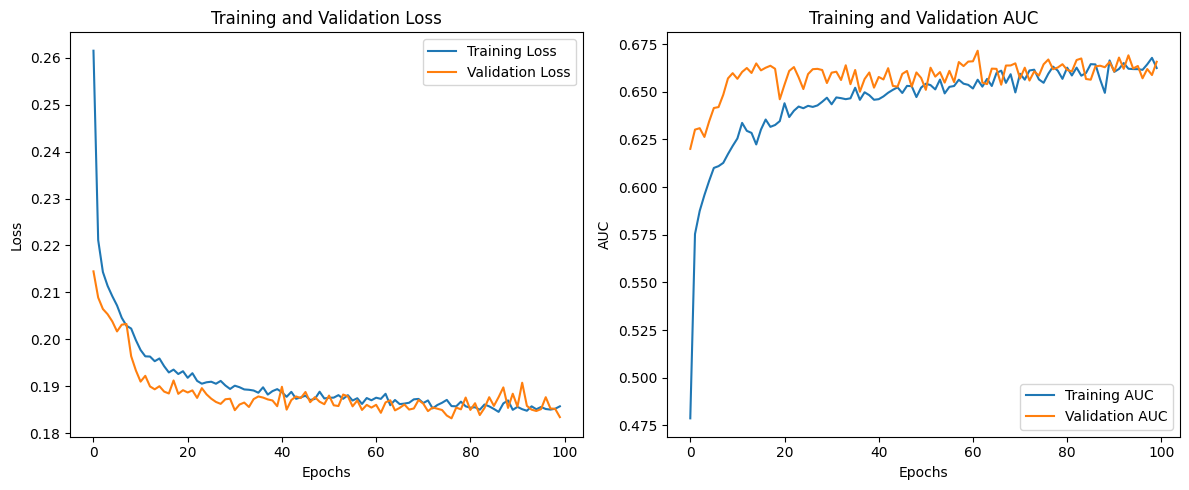

In [ ]:
plot_training_history(history)

Vemos que el mejor número de epochs es alrededor de 60 (a partir de ahí, tanto la loss como el auc pr de validación se estancan)

Comparamos los resultados con la rn anterior:

In [ ]:
model = build_rn_inicial()
history = model.fit(x_train_rn, y_train_rn, validation_data=(x_val_rn,y_val_rn), epochs=100, shuffle=True, batch_size=32)

Epoch 1/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - auc_pr: 0.4184 - loss: 0.2765 - val_auc_pr: 0.6317 - val_loss: 0.1967
Epoch 2/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - auc_pr: 0.6063 - loss: 0.1991 - val_auc_pr: 0.6394 - val_loss: 0.1942
Epoch 3/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_pr: 0.6305 - loss: 0.1933 - val_auc_pr: 0.6427 - val_loss: 0.1883
Epoch 4/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - auc_pr: 0.6352 - loss: 0.1905 - val_auc_pr: 0.6499 - val_loss: 0.1864
Epoch 5/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - auc_pr: 0.6400 - loss: 0.1856 - val_auc_pr: 0.6479 - val_loss: 0.1842
Epoch 6/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - auc_pr: 0.6485 - loss: 0.1846 - val_auc_pr: 0.6386 - val_loss: 0.1944
Epoch 7/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - auc_pr: 0.6530 - loss: 0.1865 - val_auc_pr: 0.6445 - val_loss: 0.1865
Epoch 8/100
875/875 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - auc_pr: 0.6613 - loss: 0.1787 - val_auc_pr: 0.6491 - val_loss: 0.1850


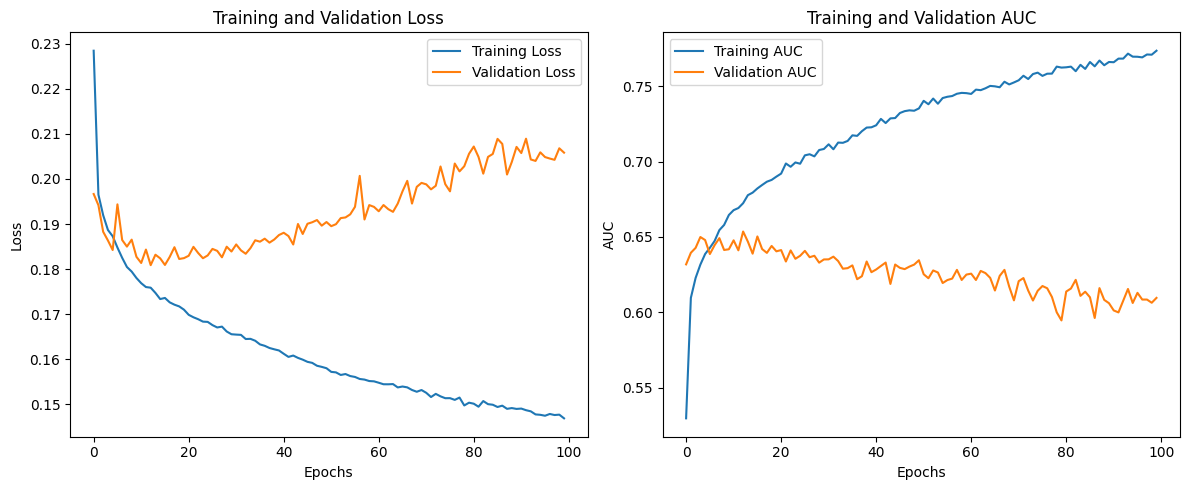

In [ ]:
plot_training_history(history)

In [ ]:
best_params_rn = {
    'model': build_rn_optimizado,
    'epochs': 60,
    'batch_size': 64,
    'verbose': 0,
    'random_state': 44,
}

In [ ]:
rn = KerasClassifier(**best_params_rn)
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6341): ', calculate_cv_aucpr(rn, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6341):  0.6457


***

##### 9.1.8 Voting classifier (baseline = 0.6635)

Veremos primero de todo el score en validación cruzada simplemente con los hiperparámetros de los 7 modelos base optimizados:

In [ ]:
estimators = [
      ('lr', LogisticRegression(**best_params_lr)),
      ('dt', DecisionTreeClassifier(**best_params_dt)),
      ('kn', KNeighborsClassifier(**best_params_knn)),
      ('rn', KerasClassifier(**best_params_rn)),
      ('rf', RandomForestClassifier(**best_params_rf)),
      ('xgb', xgboost.XGBClassifier(**best_params_xgb)),
      ('hist', HistGradientBoostingClassifier(**best_params_hist))
]

voting = VotingClassifier(estimators=estimators,  voting='soft')
print('Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6341): ', calculate_cv_aucpr(voting, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros (baseline=0.6341):  0.6695


Ahora pasaremos a optimizar los pesos de cada uno de los 7 modelos del voting:

(Entrenaremos el voting 5 veces en 5 carpetas de cv diferentes, para después, ir cambiando los pesos de estos y obtener el mejor AUC PR en cv, de esta manera no tenemos que entrenar el modelo de nuevo cada vez que cambiamos los pesos):

In [ ]:
def train_voting_cv(x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)
  models = []

  for train_index, test_index in skf.split(x,y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    voting = VotingClassifier(estimators=estimators, voting='soft')
    voting.fit(X_train, y_train)
    models.append(voting)

  return models

voting_models_trained = train_voting_cv(x_train_prepared, y_train_prepared) #obtenemos los 5 voting entrenados en cada una de las 5 folds

Definimos la función para calcular la media de AUC PR en las 5 folds en base a unos pesos proporcionados como parámetro (utilizaremos los 5 voting ya entrenados previamente, solo variaremos los pesos):

In [ ]:
def cv_score_voting(models, new_weights, x, y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)
  indice = 0
  auc_pr = []
  for train_index, test_index in skf.split(x,y):
    X_train, X_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    models[indice].weights = new_weights
    preds_test = models[indice].predict_proba(X_test)[:,1]

    score = average_precision_score(y_test, preds_test)
    auc_pr.append(score)
    indice = indice + 1

  return np.mean(auc_pr)

Buscamos los mejores pesos para cada uno de los 7 modelos (valores entre 0 y 1). Estos pesos los iremos pasando a la función anterior para obtener el AUC PR medio en validación cruzada:

In [ ]:
def objective_voting(trial):
     w1 = trial.suggest_uniform('w1', 0, 1)
     w2 = trial.suggest_uniform('w2', 0, 1)
     w3 = trial.suggest_uniform('w3', 0, 1)
     w4 = trial.suggest_uniform('w4', 0, 1)
     w5 = trial.suggest_uniform('w5', 0, 1)
     w6 = trial.suggest_uniform('w6', 0, 1)
     w7 = trial.suggest_uniform('w7', 0, 1)

     weights_propuestos=[w1,w2,w3,w4,w5,w6,w7]

     cv = cv_score_voting(voting_models_trained, weights_propuestos, x_train_prepared, y_train_prepared)

     return cv

opt = optuna.create_study(direction='maximize')
opt.optimize(objective_voting, n_trials=80, show_progress_bar=True)

opt_voting_params = opt.best_params
print('--------------------------------------')
print(opt_voting_params)

[I 2024-06-16 11:41:09,649] A new study created in memory with name: no-name-f728e11e-81b6-46fd-a4e3-5350f796dfd2


  0%|          | 0/80 [00:00<?, ?it/s]

[I 2024-06-16 11:41:27,757] Trial 0 finished with value: 0.667497036226085 and parameters: {'w1': 0.43186093595411545, 'w2': 0.3213947257540084, 'w3': 0.5388193891918913, 'w4': 0.9584752705566127, 'w5': 0.660934417868036, 'w6': 0.1652351478772176, 'w7': 0.4634414006320541}. Best is trial 0 with value: 0.667497036226085.
[I 2024-06-16 11:41:40,565] Trial 1 finished with value: 0.6698263687299655 and parameters: {'w1': 0.5629366290891394, 'w2': 0.32348286484558086, 'w3': 0.9136828764440355, 'w4': 0.5032085949256363, 'w5': 0.7714874034616301, 'w6': 0.6570090232494413, 'w7': 0.9665895820438564}. Best is trial 1 with value: 0.6698263687299655.
[I 2024-06-16 11:41:53,060] Trial 2 finished with value: 0.6691117427612794 and parameters: {'w1': 0.5739505726394175, 'w2': 0.7411094317635062, 'w3': 0.2663359144999623, 'w4': 0.09407738569072899, 'w5': 0.4174054703102311, 'w6': 0.6849460372317953, 'w7': 0.17743194655618655}. Best is trial 1 with value: 0.6698263687299655.
[I 2024-06-16 11:42:05,354]

In [ ]:
best_params_voting= {
    'voting' : 'soft',
    'weights' : [0.07706639223827505, 0.2543946849801558, 0.12439539774863495, 0.05917170893708934, 0.3646432394020082, 0.8664926603286063, 0.7899967421503448]
}

In [ ]:
voting = VotingClassifier(estimators=estimators,  **best_params_voting)
print('Resultados CV AUC PR tras ajustar hiperparámetros de los modelos base y pesos (baseline=0.6341): ', calculate_cv_aucpr(voting, x_train_prepared, y_train_prepared))

Resultados CV AUC PR tras ajustar hiperparámetros de los modelos base y pesos (baseline=0.6341):  0.6773


***

#### 9.2 Modelos y cálculo de métricas

In [ ]:
def initialize_models():

  estimators = [
      ('lr', LogisticRegression(**best_params_lr)),
      ('dt', DecisionTreeClassifier(**best_params_dt)),
      ('kn', KNeighborsClassifier(**best_params_knn)),
      ('rn', KerasClassifier(**best_params_rn)),
      ('rf', RandomForestClassifier(**best_params_rf)),
      ('xgb', xgboost.XGBClassifier(**best_params_xgb)),
      ('hist', HistGradientBoostingClassifier(**best_params_hist))
  ]

  dict_estimators = dict(estimators)

  voting = VotingClassifier(estimators=estimators, **best_params_voting)
  dict_estimators['voting'] = voting

  return dict_estimators

Funciones para cálculo de métricas:

In [ ]:
def probas_to_abs(probas, umbral=0.5):
  abs = []
  for proba in probas:
    if (proba >= umbral): abs.append(1)
    else: abs.append(0)
  return abs

def calculate_cv_metrics(estimator,x,y):
  skf = StratifiedKFold(n_splits=5, shuffle=True,random_state=44)

  scores_auc_pr = []
  scores_precision = []
  scores_recall = []
  scores_f1 = []
  scores_accuracy = []
  scores_roc = []

  for i, (train_idx, test_idx) in enumerate(skf.split(x, y)):

    X_train, X_test = x[train_idx], x[test_idx]
    Y_train, Y_test = y[train_idx], y[test_idx]

    model = clone(estimator)
    model.fit(X_train, Y_train)
    preds_test = model.predict_proba(X_test)[:,1]

    scores_auc_pr.append(average_precision_score(Y_test, preds_test))
    scores_precision.append(precision_score(Y_test, probas_to_abs(preds_test)))
    scores_recall.append(recall_score(Y_test, probas_to_abs(preds_test)))
    scores_f1.append(f1_score(Y_test, probas_to_abs(preds_test)))
    scores_accuracy.append(accuracy_score(Y_test, probas_to_abs(preds_test)))
    scores_roc.append(roc_auc_score(Y_test, preds_test))

  mean_auc_pr = round(np.mean(scores_auc_pr), 4)
  mean_precision = round(np.mean(scores_precision), 4)
  mean_recall = round(np.mean(scores_recall), 4)
  mean_f1 = round(np.mean(scores_f1), 4)
  mean_accuracy = round(np.mean(scores_accuracy), 4)
  mean_roc = round(np.mean(scores_roc), 4)

  return mean_auc_pr, mean_precision, mean_recall, mean_f1, mean_accuracy, mean_roc


def calculate_pr_cv():
  modelos = initialize_models()
  scores = []
  for key, model in modelos.items():
      score,_,_,_,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      scores.append(score)
      print(f'CV -> AUC PR score for {key}: ', score)
  print('')
  print('Mean AUC PR score: ', round(np.mean(scores), 4))


def calculate_baseline_metrics_cv():
  modelos = initialize_models()
  for key, model in modelos.items():
      auc_pr, precision, recall, f1,_,_ = calculate_cv_metrics(model, x_train_prepared, y_train_prepared)
      print(f'CV -> AUC PR score for {key}: ', auc_pr)
      print(f'CV -> Precision score for {key}: ', precision)
      print(f'CV -> Recall score for {key}: ', recall)
      print(f'CV -> F1 score for {key}: ', f1)
      print('')
      print('**********************************')
      print('')

***

#### 9.3 Resultados de AUC PR tras ajustar hiperparámtros

In [ ]:
calculate_pr_cv()

CV -> AUC PR score for lr:  0.5888
CV -> AUC PR score for dt:  0.6329
CV -> AUC PR score for kn:  0.5741
CV -> AUC PR score for rn:  0.6457
CV -> AUC PR score for rf:  0.6702
CV -> AUC PR score for xgb:  0.672
CV -> AUC PR score for hist:  0.6758
CV -> AUC PR score for voting:  0.6773

Mean AUC PR score:  0.6421


***

#### 9.4 Métricas CV tras ajustar hiperparámetros


In [ ]:
calculate_baseline_metrics_cv()

CV -> AUC PR score for lr:  0.5888
CV -> Precision score for lr:  0.6676
CV -> Recall score for lr:  0.4015
CV -> F1 score for lr:  0.5009

**********************************

CV -> AUC PR score for dt:  0.6329
CV -> Precision score for dt:  0.6385
CV -> Recall score for dt:  0.5364
CV -> F1 score for dt:  0.5815

**********************************

CV -> AUC PR score for kn:  0.5741
CV -> Precision score for kn:  0.6716
CV -> Recall score for kn:  0.3122
CV -> F1 score for kn:  0.4258

**********************************

CV -> AUC PR score for rn:  0.6457
CV -> Precision score for rn:  0.6285
CV -> Recall score for rn:  0.5514
CV -> F1 score for rn:  0.5843

**********************************

CV -> AUC PR score for rf:  0.6702
CV -> Precision score for rf:  0.656
CV -> Recall score for rf:  0.5443
CV -> F1 score for rf:  0.5946

**********************************

CV -> AUC PR score for xgb:  0.672
CV -> Precision score for xgb:  0.6779
CV -> Recall score for xgb:  0.5011
CV -> F1 sc

***